<a href="https://colab.research.google.com/github/Suhwan-Tcha/Vision/blob/main/efficientnetb3_cutmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install timm

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.optim import lr_scheduler
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchvision.transforms import functional as F
from torchvision.models import resnet34, ResNet34_Weights, vit_b_16, ViT_B_16_Weights

In [ ]:
# 재현성을 위해 시드를 설정하는 함수 정의
# 이 함수를 통해 결과를 매번 동일하게 재현할 수 있도록 합니다.
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)  # 시드 설정

In [ ]:
#점수 합산을 위한 코드
def calculate_score(test_accuracy, total_params, model_size_mb):
    base_params = 11.7 * 10**6  # 기준 모델인 ResNet-18의 파라미터 수 (11.7M)
    base_memory = 44.6  # 기준 모델의 메모리 크기 (44.6MB)

    max_accuracy_score = 50
    max_param_score = 25
    max_memory_score = 25

    accuracy_score = min(test_accuracy * 0.5, max_accuracy_score)

    if total_params <= base_params:
        param_score = max_param_score
    else:
        k_p = 0.2
        param_score = max(max_param_score - 10, max_param_score * math.exp(-k_p * (total_params - base_params) / base_params))

    if model_size_mb <= base_memory:
        memory_score = max_memory_score
    else:
        k_m = 0.2
        memory_score = max(max_memory_score - 10, max_memory_score * math.exp(-k_m * (model_size_mb - base_memory) / base_memory))

    total_score = accuracy_score + param_score + memory_score

    print("\n========== Model Evaluation Score ==========")
    print(f"Test Accuracy Score: {accuracy_score:.2f} / {max_accuracy_score}")
    print(f"Parameter Efficiency Score: {param_score:.2f} / {max_param_score}")
    print(f"Memory Efficiency Score: {memory_score:.2f} / {max_memory_score}")
    print(f"Total Score: {total_score:.2f} / 100")
    print("============================================")

In [ ]:
# Dataset 경로 설정
train_valid_root = '/content/drive/My Drive/oxford_pet_trainvalid'
test_root =  '/content/drive/My Drive/oxford_pet_test'

In [ ]:
# 학습 데이터 전용 transform
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),

    #data augmentaton 적용
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 80%~100% 크기에서 랜덤 자름
    transforms.ColorJitter(), # 색상 변화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Oxford-IIIT Pet Dataset 로드
# 'trainval' split을 사용하고, 지정한 변환 적용
# 필요한 경우 자동으로 다운로드
dataset_trainvalid = OxfordIIITPet(root=train_valid_root, split='trainval', target_types='category',
                        transform=transform_train , download=True)

In [ ]:
# test Dataset에 쓰일 전치리를 포함하고 있는 부분
# test 데이터에서는 원본 이미지 그대로의 상태를 유지하
# test에 데이터 증강이 적용되면 모델이 예상하지 못한 데이터로 평가될 수 있어 평가 결과가 왜곡될 위험
# validation 및 test 데이터 transform (기본 전처리만 포함)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이번에는 테스트 데이터셋에 사용할 것이므로 'test' split을 사용
test_dataset = OxfordIIITPet(root=test_root, split='test', target_types='category',
                        transform=transform_val , download=True)

In [ ]:
# Dataset을 학습, train, validation셋으로 분할
# 70%는 학습, 30%는 validation으로 분할
total_size = len(dataset_trainvalid)
train_size = int(0.7 * total_size)
val_size = int(0.3 * total_size)

In [ ]:
# random_split을 사용해 Dataset을 나눔
train_dataset, val_dataset = random_split(dataset_trainvalid, [train_size, val_size])

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Total samples: 3680
Training samples: 2576
Validation samples: 1104


In [ ]:
# test Dataset은 나눌 필요가 없음
print(f"Test samples: {len(test_dataset)}")

Test samples: 3669


In [ ]:
def mixup_loader(data_loader, alpha=1.0):
    for data, targets in data_loader:
        # Mixup 증강 적용
        lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
        batch_size = data.size(0)
        index = torch.randperm(batch_size)  # 배치 내에서 랜덤하게 섞기

        # 두 이미지를 선형적으로 섞음
        mixed_data = lam * data + (1 - lam) * data[index]

        # 두 라벨을 혼합
        targets_a = targets
        targets_b = targets[index]

        yield mixed_data, targets_a, targets_b, lam

In [ ]:
# 배치 크기 설정
## 배치 사이즈는 처음에는 32로 시작
batch_size = 64

# DataLoader 생성: 데이터를 배치 단위로 로드하고, 학습 시 무작위 섞기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")

Training DataLoader: 41 batches
Validation DataLoader: 18 batches


In [ ]:
train_loader_mixup = mixup_loader(train_loader, alpha=1.0)

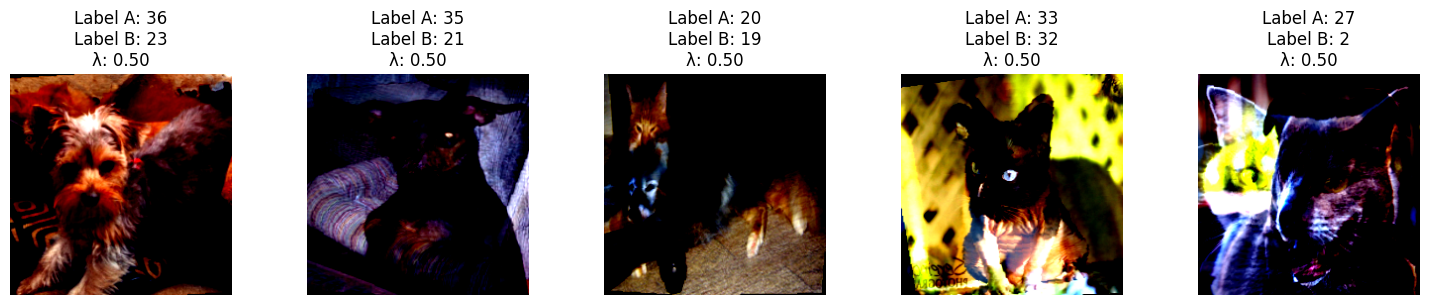

In [ ]:
# Mixup 데이터를 로드
mixed_images, targets_a, targets_b, lam = next(iter(train_loader_mixup))

# 이미지를 화면에 표시
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 1행 5열로 subplot 생성

for i in range(5):
    # 이미지 텐서를 numpy 배열로 변환 (채널 순서 변경: (C, H, W) -> (H, W, C))
    image = mixed_images[i].permute(1, 2, 0).cpu().numpy()

    # 이미지 픽셀 값을 [0, 1] 범위로 스케일링 (필요할 경우)
    image = np.clip(image, 0, 1)

    # 두 라벨을 표시 (lam 비율로 라벨 혼합)
    label_a = targets_a[i].item()
    label_b = targets_b[i].item()
    axes[i].imshow(image)
    axes[i].set_title(f"Label A: {label_a}\nLabel B: {label_b}\nλ: {lam:.2f}")
    axes[i].axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()


In [ ]:
# test_loader의 shuffle 매개변수는 항상 False로 되어 있어야 함
# 만약 test 데이터가 무작위로 섞일 경우 모델의 평가 결과가 달라질 수 있음
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Test DataLoader: {len(test_loader)} batches")

Test DataLoader: 58 batches


In [ ]:
# 데이터로더 내부 이미지를 보기 위해 image와 라벨을 따로 구별
images, labels = next(iter(train_loader))

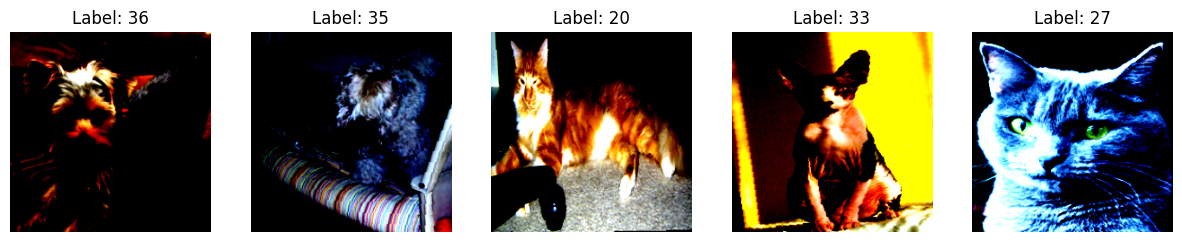

In [ ]:
# 이미지를 화면에 표시
fig, axes = plt.subplots(1, 5, figsize=(15, 3)) # 1행 5열로 이미지를 표시할 subplot을 생성

for i in range(5):
    # 이미지를 numpy 배열로 변환하고, 채널 순서를 변경
    image = images[i].permute(1, 2, 0).numpy()

    # 이미지를 표시하고, 제목을 설정
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off') # 축을 숨김

plt.show()

In [ ]:
# # Pre-trained ResNet-34 모델 불러오기
# # ImageNet으로 사전 학습된 가중치를 사용하여 모델 초기화
# model = models.resnet34(pretrained=True)
# # pretrained=True를 사용하여 ImageNet Dataset으로 사전 학습된 가중치를 불러옴
# # 이렇게 불러온 모델은 기존의 이미지 분류 작업에 이미 학습된 가중치를 가지고 있기 때문에,
# # 이를 새로운 Dataset에 활용하는 것이 전이 학습

# # 모델의 마지막 layer를 Oxford-IIIT Pet Dataset에 맞게 수정
# # 총 37개의 클래스가 있으므로 출력 뉴런 수를 37로 설정
# num_classes = 37
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# # ResNet-34의 마지막 완전 연결 layer(fc)를 num_classes = 37로 수정하여
# # 현재 학습 중인 Oxford-IIIT Pet Dataset에 맞게 조정
# # model.fc는 원래 ImageNet에 맞춰져 1000개의 클래스를 예측하도록 설계되어 있기 때문에,
# # 이를 현재 Dataset에 맞게 클래스 수를 37로 설정

!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
import torch.nn as nn

model = EfficientNet.from_pretrained('efficientnet-b2')

num_classes = 37
model._fc = nn.Sequential(
    nn.Dropout(p=0.3),  # Dropout 추가
    nn.Linear(model._fc.in_features, num_classes)
)


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=c08af1b408e81bb2d7f79daa7cbbf93a0bf647546ebcf0d664484a8ab6f05a8e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 336MB/s]

Loaded pretrained weights for efficientnet-b2


In [ ]:
# GPU 사용 여부를 확인하여 장치를 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델을 GPU로 이동
print('device is', device)

device is cuda:0


In [ ]:
# loss function와 옵티마이저 설정
# CrossEntropyLoss는 다중 클래스 분류에서 주로 사용
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model._fc.parameters(), lr=0.0005, weight_decay=0.01, momentum=0.9, alpha=0.95)  # 마지막 layer만 학습

# 이 부분은 옵티마이저가 모델의 마지막 완전 연결 layer(fully connected layer)에만 학습을 적용하도록 지정하고 있음
# model.fc.parameters()는 ResNet-34의 마지막 layer(fc)의 weight, bias 파라미터를 반환
# 따라서 옵티마이저는 이 마지막 layer만 업데이트하며, 나머지 layer들은 사전 학습된 상태로 고정됨
for param in model.parameters():
    param.requires_grad = True ## fine tuning
# 학습률 스케줄러 설정
# 일정 epochch마다 학습률을 감소시켜 학습이 수렴하도록 함
# 스케쥴러 설정
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch [1/3], Step [0/41], Loss: 3.6580
Epoch [1/3], Step [10/41], Loss: 2.5739
Epoch [1/3], Step [20/41], Loss: 1.7134
Epoch [1/3], Step [30/41], Loss: 1.1418
Epoch [1/3], Step [40/41], Loss: 0.7785
Epoch [1/3], Train Loss: 1.9678, Train Accuracy: 50.16%
Validation Step [0/18], Loss: 0.9029
Validation Step [10/18], Loss: 0.6687
Validation Loss: 0.7446, Validation Accuracy: 77.36%
Epoch [2/3], Step [0/41], Loss: 1.0781
Epoch [2/3], Step [10/41], Loss: 0.9987
Epoch [2/3], Step [20/41], Loss: 1.0681
Epoch [2/3], Step [30/41], Loss: 0.9714
Epoch [2/3], Step [40/41], Loss: 1.2374
Epoch [2/3], Train Loss: 1.0188, Train Accuracy: 74.38%
Validation Step [0/18], Loss: 0.7208
Validation Step [10/18], Loss: 0.6856
Validation Loss: 0.6436, Validation Accuracy: 83.06%
Epoch [3/3], Step [0/41], Loss: 0.9744
Epoch [3/3], Step [10/41], Loss: 1.1195
Epoch [3/3], Step [20/41], Loss: 1.1146
Epoch [3/3], Step [30/41], Loss: 0.9137
Epoch [3/3], Step [40/41], Loss: 0.9939
Epoch [3/3], Train Loss: 0.9618, Tr

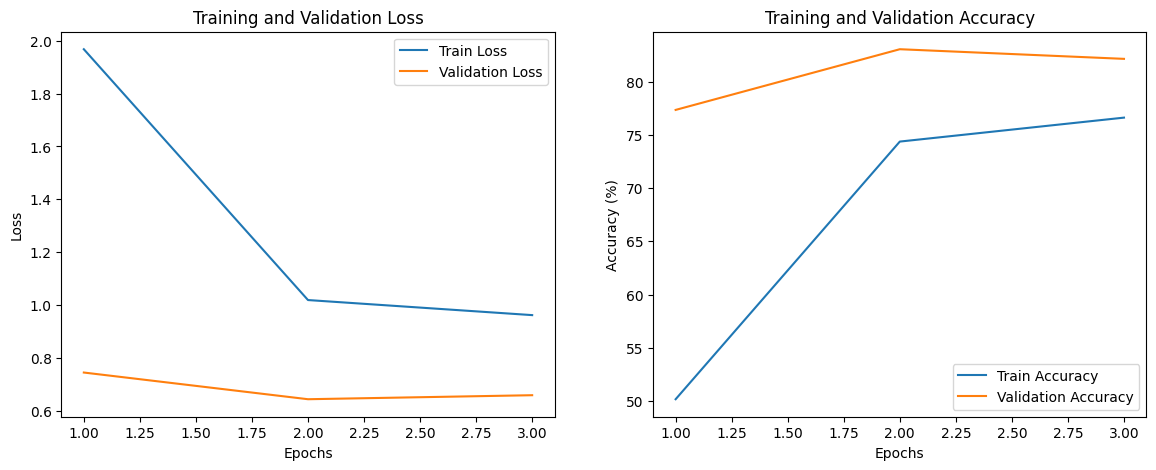

In [ ]:
# # 모델 학습 함수 정의
# # Trainning 과정에서 loss과 정확도를 기록하고, validation 및 test Dataset으로 평가합니다.
# # 참고 #
# # 첫 번째 트레이닝 epoch는 시간이 많이 소요될 수 있습니다.
# def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
#     train_losses, val_losses = [], []
#     train_accuracies, val_accuracies = [], []

#     for epoch in range(num_epochs):
#         model.train()  # Trainning 모드로 설정
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         # 학습 데이터로 모델을 학습시킵니다.
#         for batch_idx, (inputs, labels) in enumerate(train_loader):
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()  # 기울기 초기화
#             outputs = model(inputs)  # 모델의 예측값 계산
#             loss = criterion(outputs, labels)  # loss 계산
#             loss.backward()  # 역전파 수행
#             optimizer.step()  # 옵티마이저를 사용해 파라미터 업데이트
#             running_loss += loss.item()  # loss 누적
#             _, predicted = torch.max(outputs, 1)  # 가장 높은 값을 가진 클래스 선택
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             # 로그 추가: 배치별 손실 및 정확도 출력
#             if batch_idx % 10 == 0:  # 10개 배치마다 로그 출력
#                 print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

#         scheduler.step()  # 학습률 업데이트

#         # epoch별 loss과 정확도 계산
#         train_loss = running_loss / len(train_loader)
#         train_accuracy = 100 * correct / total
#         train_losses.append(train_loss)
#         train_accuracies.append(train_accuracy)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

#         # validation 단계 - trainning이 아닌 evaluation 모드로 전환합니다.
#         model.eval()
#         val_loss = 0.0
#         val_correct = 0
#         val_total = 0

#         # validation Dataset을 사용해 모델을 평가합니다.
#         with torch.no_grad():
#             for batch_idx, (inputs, labels) in enumerate(val_loader):
#                 inputs, labels = inputs.to(device), labels.to(device)
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item()
#                 _, predicted = torch.max(outputs, 1)
#                 val_total += labels.size(0)
#                 val_correct += (predicted == labels).sum().item()

#                 # 로그 추가: 배치별 validation 손실 및 정확도 출력
#                 if batch_idx % 10 == 0:  # 10개 배치마다 로그 출력
#                     print(f"Validation Step [{batch_idx}/{len(val_loader)}], Loss: {loss.item():.4f}")

#         val_loss = val_loss / len(val_loader)
#         val_accuracy = 100 * val_correct / val_total
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)
#         print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

#     # test 단계 - 학습이 완료된 후 test Dataset으로 평가합니다.
#     print("\nEvaluating on Test Set...")
#     model.eval()
#     test_loss = 0.0
#     test_correct = 0
#     test_total = 0

#     with torch.no_grad():
#         for batch_idx, (inputs, labels) in enumerate(test_loader):
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item()
#             _, predicted = torch.max(outputs, 1)
#             test_total += labels.size(0)
#             test_correct += (predicted == labels).sum().item()

#             # 로그 추가: 배치별 test 손실 및 정확도 출력
#             if batch_idx % 10 == 0:  # 10개 배치마다 로그 출력
#                 print(f"Test Step [{batch_idx}/{len(test_loader)}], Loss: {loss.item():.4f}")

#     # test 결과 출력
#     test_loss = test_loss / len(test_loader)
#     test_accuracy = 100 * test_correct / test_total
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

#     # trainning loss 및 validation loss와 정확도 시각화
#     epochs_range = range(1, num_epochs + 1)
#     plt.figure(figsize=(14, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, train_losses, label='Train Loss')
#     plt.plot(epochs_range, val_losses, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
#     plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy (%)')
#     plt.title('Training and Validation Accuracy')
#     plt.legend()

#     plt.show()

#     return test_accuracy

# # 모델 학습 및 테스트 수행
# test_accuracy = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=3)


In [ ]:
# 모델 학습 함수 정의
def train_model(model, train_loader, train_loader_mixup, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10, mixup_prob=0.5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Training 모드로 설정
        running_loss = 0.0
        correct = 0
        total = 0

        # 두 데이터로더를 번갈아가며 학습
        for (inputs, labels), (inputs_mixup, labels_mixup) in zip(train_loader, train_loader_mixup):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs_mixup, labels_mixup = inputs_mixup.to(device), labels_mixup.to(device)

            # Mixup을 일정 확률로 적용 (train_loader_mixup을 사용하면 mixup을 적용)
            if random.random() < mixup_prob:
                inputs, labels, _ = mixup_data(inputs, labels)  # Mixup 적용

            optimizer.zero_grad()  # 기울기 초기화
            outputs = model(inputs)  # 모델의 예측값 계산
            loss = criterion(outputs, labels)  # loss 계산
            loss.backward()  # 역전파 수행
            optimizer.step()  # 옵티마이저를 사용해 파라미터 업데이트
            running_loss += loss.item()  # loss 누적
            _, predicted = torch.max(outputs, 1)  # 가장 높은 값을 가진 클래스 선택
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 로그 추가: 배치별 손실 및 정확도 출력
            if total % 10 == 0:  # 10개 배치마다 로그 출력
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{total}/{len(train_loader)}], Loss: {loss.item():.4f}")

        scheduler.step()  # 학습률 업데이트

        # epoch별 loss과 정확도 계산
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # validation 단계 - trainning이 아닌 evaluation 모드로 전환합니다.
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # validation Dataset을 사용해 모델을 평가합니다.
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # 로그 추가: 배치별 validation 손실 및 정확도 출력
                if batch_idx % 10 == 0:  # 10개 배치마다 로그 출력
                    print(f"Validation Step [{batch_idx}/{len(val_loader)}], Loss: {loss.item():.4f}")

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # test 단계 - 학습이 완료된 후 test Dataset으로 평가합니다.
    print("\nEvaluating on Test Set...")
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            # 로그 추가: 배치별 test 손실 및 정확도 출력
            if batch_idx % 10 == 0:  # 10개 배치마다 로그 출력
                print(f"Test Step [{batch_idx}/{len(test_loader)}], Loss: {loss.item():.4f}")

    # test 결과 출력
    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # trainning loss 및 validation loss와 정확도 시각화
    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return test_accuracy

# 모델 학습 및 테스트 수행
test_accuracy = train_model(model, train_loader, train_loader_mixup, val_loader, test_loader, criterion, optimizer, scheduler, num_epochs=3)


ValueError: too many values to unpack (expected 2)

In [ ]:
def mixup_data(x, y, alpha=1.0):
    """Mixup 데이터 생성"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Mixup 손실 계산"""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
!pip install ray[tune]
!pip install wandb

In [ ]:
# 학습된 모델 저장
torch.save(model.state_dict(), '/content/drive/My Drive/DeepLearning/Parrot/efficientnet_b2_002.pth')
# 위에서 저장한 모델을 제출하셔야 하므로, 경로를 잘 지정하시기 바랍니다.
# 이름을 잘 지정하셔서 제출하시기를 바랍니다.

In [ ]:
# 모델의 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 7753127


In [ ]:
# 모델의 메모리 크기 계산
model_size = 0
for param in model.parameters():
    model_size += param.numel() * param.element_size()
model_size_mb = model_size / (1024 ** 2)
print(f"Approximate model size: {model_size_mb:.2f} MB")

Approximate model size: 29.58 MB


In [ ]:
calculate_score(test_accuracy, total_params, model_size_mb)


========== Model Evaluation Score ==========
Test Accuracy Score: 44.04 / 50
Parameter Efficiency Score: 25.00 / 25
Memory Efficiency Score: 25.00 / 25
Total Score: 94.04 / 100


<ipython-input-30-0fd6c69ff1f6>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/DeepLearning/Parrot/efficientnet_b

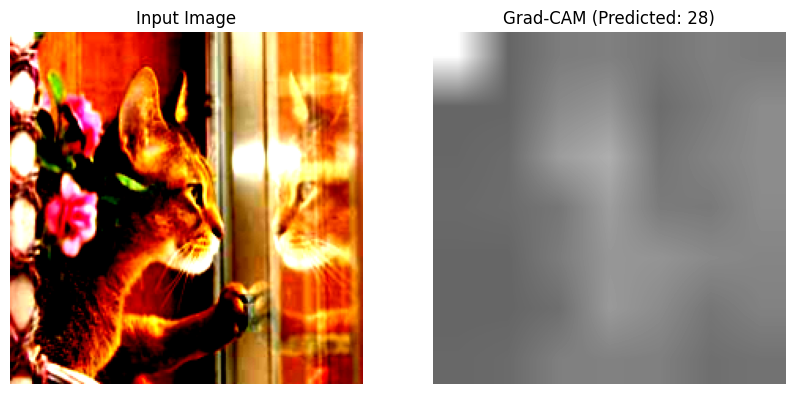

In [ ]:
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

# EfficientNet-B2 모델 로드 및 커스터마이징
weights = EfficientNet_B2_Weights.IMAGENET1K_V1
model = efficientnet_b2(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/My Drive/DeepLearning/Parrot/efficientnet_b2_002.pth'), strict=False)  # 저장된 가중치 로드
model = model.to(device)
model.eval()

# Grad-CAM 초기화 및 사용 설정
# EfficientNet-B2의 마지막 convolutional 블록은 `features.8`
cam_extractor = GradCAM(model, target_layer='features.8')

# test Dataset에서 샘플 이미지 선택
test_image, _ = test_dataset[15]
input_tensor = test_image.unsqueeze(0).to(device)  # 배치 차원 추가

# 예측 및 Grad-CAM 생성
output = model(input_tensor)
predicted_class = output.argmax().item()
cam = cam_extractor(predicted_class, output)

# Grad-CAM 결과를 원본 이미지 크기에 맞게 리사이즈
gradcam_resized = F.resize(cam[0], size=(test_image.shape[1], test_image.shape[2]))
gradcam_resized = gradcam_resized.cpu().numpy()  # NumPy 배열로 변환
gradcam_resized = np.squeeze(gradcam_resized)  # 불필요한 차원 제거

# Grad-CAM 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(test_image.cpu().numpy(), (1, 2, 0)))
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradcam_resized, cmap='gray', alpha=0.6)
plt.title(f"Grad-CAM (Predicted: {predicted_class})")
plt.axis('off')

plt.show()